# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## Первичный осмотр

In [2]:
data = pd.read_csv('/Users/daniilsobolev/Desktop/ml projects/Численные методы/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.shape

(354369, 16)

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


**Описание данных**

Признаки<br>

- DateCrawled — дата скачивания анкеты из базы<br>
- VehicleType — тип автомобильного кузова<br>
- RegistrationYear — год регистрации автомобиля<br>
- Gearbox — тип коробки передач<br>
- Power — мощность (л. с.)<br>
- Model — модель автомобиля<br>
- Kilometer — пробег (км)<br>
- RegistrationMonth — месяц регистрации автомобиля<br>
- FuelType — тип топлива<br>
- Brand — марка автомобиля<br>
- Repaired — была машина в ремонте или нет<br>
- DateCreated — дата создания анкеты<br>
- NumberOfPictures — количество фотографий автомобиля<br>
- PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
- LastSeen — дата последней активности пользователя<br>

Целевой признак<br>
- Price — цена (евро)<br>

**Процент пропусков**

In [5]:
data.isna().mean().sort_values(ascending=False).head(6) * 100

Repaired       20.079070
VehicleType    10.579368
FuelType        9.282697
Gearbox         5.596709
Model           5.560588
DateCrawled     0.000000
dtype: float64

Пропуски невозможно заполнить значениями, поэтому пометим их как 'unknown'

In [6]:
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('unknown')

In [7]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

<AxesSubplot:>

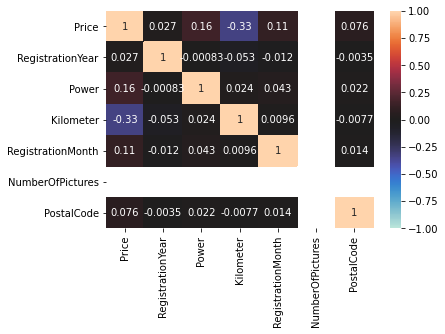

In [8]:
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, center= 0)

Посмотрим на крайнее выложенное объявление:

In [9]:
data['DateCreated'].max()

'2016-04-07 00:00:00'

Уберём те объявления, в которых указан год и месяц регистрации позже 2016-04

In [10]:
data = data[(data['RegistrationYear'] < 2016) | ((data['RegistrationYear'] == 2016) & (data['RegistrationMonth'] < 5))]

В данных присутствуют признаки, которые не важны для нас, но они могут немного исказить результаты, удалим столбцы: <br>
    - LastSeen<br>
    - DateCrawled<br>
    - PostalCode<br>
    - NumberOfPictures (они отсутствуют у всех)<br>
    - RegistrationMonth<br>
    - DateCreated<br>
   
Названия остальных столбцов переведем в змеиный регистр.

In [11]:
data = data.drop(columns = ['LastSeen', 
                     'DateCrawled',
                     'PostalCode',
                     'NumberOfPictures',
                     'RegistrationMonth',
                     'DateCreated'], axis = 1)

data.rename(columns = {'VehicleType' : 'vehicle_type', 
                     'Gearbox' : 'gearbox', 
                     'RegistrationYear' : 'registration_year', 
                     'Power' : 'power', 
                     'Model' : 'model', 
                     'Kilometer' : 'kilometer', 
                     'FuelType' : 'fuel_type',
                     'Brand' : 'brand',
                     'Repaired' : 'not_repaired',
                     'Price' : 'price'}, 
          inplace = True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335149 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              335149 non-null  int64 
 1   vehicle_type       335149 non-null  object
 2   registration_year  335149 non-null  int64 
 3   gearbox            335149 non-null  object
 4   power              335149 non-null  int64 
 5   model              335149 non-null  object
 6   kilometer          335149 non-null  int64 
 7   fuel_type          335149 non-null  object
 8   brand              335149 non-null  object
 9   not_repaired       335149 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.1+ MB


## Работа с аномалиями

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,335149.0,4500.118655,4557.056863,0.0,1100.0,2800.0,6500.0,20000.0
registration_year,335149.0,2002.131467,13.949278,1000.0,1999.0,2003.0,2007.0,2016.0
power,335149.0,111.331169,183.694278,0.0,69.0,105.0,143.0,20000.0
kilometer,335149.0,127962.771782,37985.339253,5000.0,125000.0,150000.0,150000.0,150000.0


Можно увидеть несколько аномальных величин:
- Год регистрации - максимальное и минимальное значение
- Мощность двигателя - максимальное и минимальное значение
- Цена - минимальное значение

**Год регистрации**

In [14]:
print('99% значений столбца с годом регистрации лежит в промежутке от', 
      data['registration_year'].quantile(q=0.005), 
      'до', data['registration_year'].quantile(q=0.995))

99% значений столбца с годом регистрации лежит в промежутке от 1971.0 до 2016.0


Удалим выбросы, не входящие в этот промежуток, также учитывая, чтоо последнее объявление было загружено в 2016 году

In [15]:
data['registration_year'] = data[data['registration_year'] >= 1971]['registration_year']
data['registration_year'] = data[data['registration_year'] <= 2016]['registration_year']

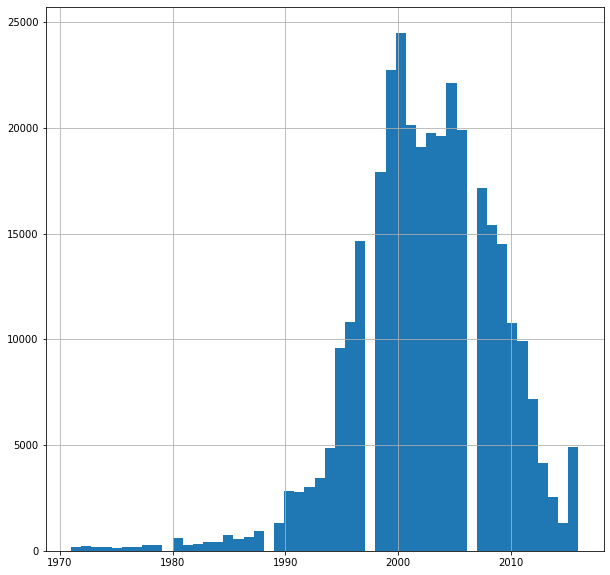

In [16]:
data['registration_year'].hist(bins=50, figsize=(10,10))
plt.show()

**Мощность двигателя**

In [17]:
data['power'] = data[data['power'] < data['power'].quantile(q=0.995)]['power']

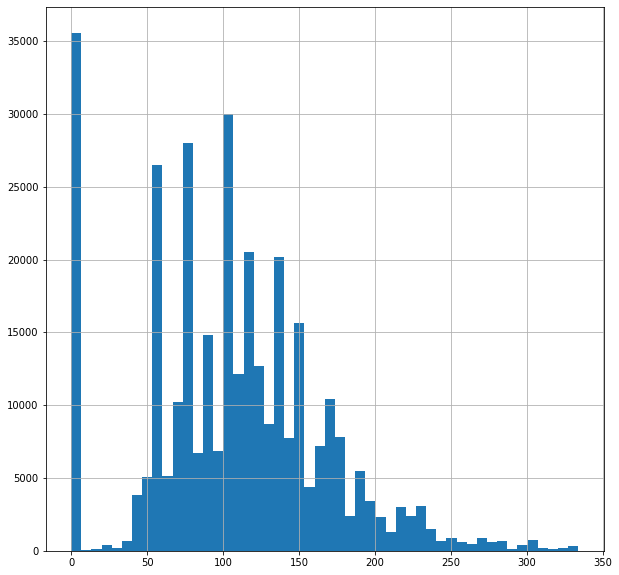

In [18]:
data['power'].hist(bins=50, figsize=(10,10))
plt.show()

Очень много значений равны нулю, возможно они появились из-за того, что продавец не знал мощность автомобиля, пропускал колонку и она автозаполнялась нулём. Уберем их, чтобы они не исказили результаты.

In [19]:
data['power'] = data[data['power'] != 0]['power']

**Цена**

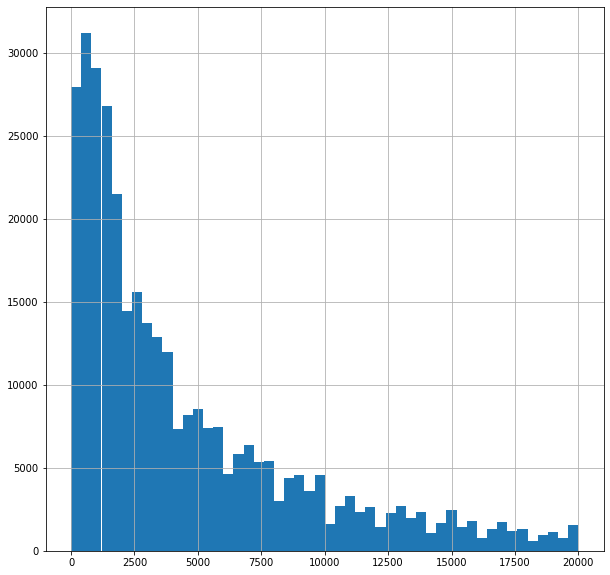

In [20]:
data['price'].hist(bins=50, figsize=(10,10))
plt.show()

Странно, что цена так распределена. Возможно, продавцы не писали действительную стоимость во время подачи объявления, вохможно, кто-то отдавал почти за даром автомобили, которые уже не пригодны к передвижения (на запчасти, на металлолом).<br>

Думаю, что такие данные могут исказить результат, уберем небольшую часть из них.

In [21]:
data['price'] = data[data['price'] > data['price'].quantile(q=0.1)]['price']

Тут я в замешательстве, так как очень малые цены составляют около 50% данных. Что делать?

(я поэксперементировал, получил ,что значение метрики наивысшее, если убрать примерно 10%)

**Проверка**

In [22]:
data = data.dropna(axis='index', how='any', subset=['price', 'power', 'registration_year'])

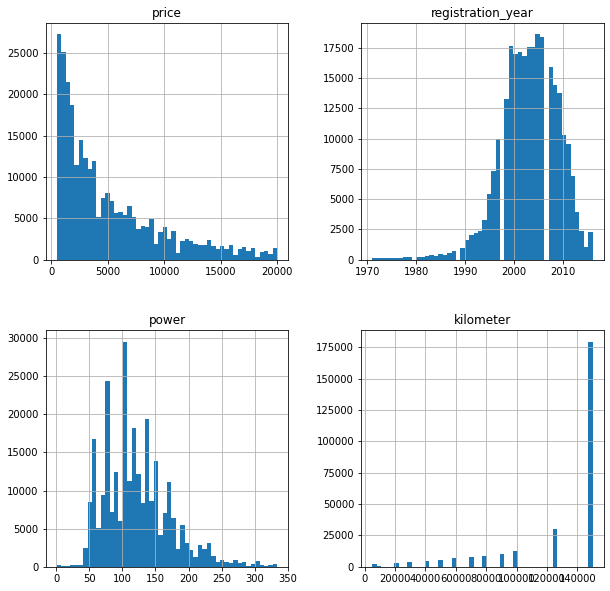

In [23]:
data.hist(bins=50, figsize=(10,10))
plt.show()

In [24]:
data.drop_duplicates(inplace=True)

In [25]:
data['price'] = data['price'].astype(int)
data['registration_year'] = data['registration_year'].astype(int)
data['power'] = data['power'].astype(int)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237255 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              237255 non-null  int64 
 1   vehicle_type       237255 non-null  object
 2   registration_year  237255 non-null  int64 
 3   gearbox            237255 non-null  object
 4   power              237255 non-null  int64 
 5   model              237255 non-null  object
 6   kilometer          237255 non-null  int64 
 7   fuel_type          237255 non-null  object
 8   brand              237255 non-null  object
 9   not_repaired       237255 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.9+ MB


**Вывод:**

При просмотре данных были выявлены пропуски в категориальных переменных, пропуски заменены на unknown.

Выявлены признаки, которые не помогут корректному обучению моделей, они были удалены.

Также выявлены аномалии и дубликаты, от которых мы избавились.

Далее<br>
Произведем обучение моделей библеотеками: Catboost, LightGBM, LinearRegression.<br>

Проверим качество моделей метрикой RMSE,<br>
Проверим время обучения, <br>
Проверим время предсказания.<br>

## Обучение моделей

In [27]:
features, target = data.drop(['price'], axis=1), data['price']

In [28]:
features.shape

(237255, 9)

In [29]:
target.shape

(237255,)

In [30]:
features_train, features_test, target_train, target_test = train_test_split (
    features, 
    target, 
    test_size = 0.25,
    random_state = 12345
)

features_valid, features_test, target_valid, target_test = train_test_split (
    features_test, 
    target_test, 
    test_size = 0.5,
    random_state = 12345
)

### CatBoost

In [31]:
info = ['CatBoost']

In [32]:
cat_features = list(features_train.select_dtypes(include=['object']).columns)

In [33]:
mse = 2500
best_rate, best_verb = 0.1, 1

for rate in np.arange(0.1,1.1, 0.1):
    for verb in range(1,31, 2):
        model = CatBoostRegressor (
    iterations=140, 
    learning_rate=rate, 
    verbose=verb, 
    cat_features=cat_features, 
    random_seed=12345
    )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    if (mean_squared_error(target_valid, predictions) ** 0.5) < mse:
        best_rate = rate
        best_verb = verb
        mse = mean_squared_error(target_valid, predictions) ** 0.5

0:	learn: 4305.7761920	total: 108ms	remaining: 15.1s
29:	learn: 1957.7013563	total: 923ms	remaining: 3.38s
58:	learn: 1796.3975716	total: 1.48s	remaining: 2.03s
87:	learn: 1737.2631661	total: 1.94s	remaining: 1.15s
116:	learn: 1697.0258205	total: 2.46s	remaining: 484ms
139:	learn: 1675.3134825	total: 2.83s	remaining: 0us
0:	learn: 4009.9988909	total: 42.2ms	remaining: 5.86s
29:	learn: 1789.2587041	total: 759ms	remaining: 2.78s
58:	learn: 1703.8141690	total: 1.21s	remaining: 1.66s
87:	learn: 1654.8388801	total: 1.66s	remaining: 979ms
116:	learn: 1628.7121529	total: 2.11s	remaining: 416ms
139:	learn: 1613.1620607	total: 2.5s	remaining: 0us
0:	learn: 3729.5644418	total: 25.3ms	remaining: 3.51s
29:	learn: 1746.7812405	total: 594ms	remaining: 2.18s
58:	learn: 1662.1990375	total: 1.08s	remaining: 1.49s
87:	learn: 1626.7190130	total: 1.58s	remaining: 937ms
116:	learn: 1598.5473833	total: 2.09s	remaining: 411ms
139:	learn: 1584.1977190	total: 2.55s	remaining: 0us
0:	learn: 3468.1967257	total: 

In [34]:
best_rate, best_verb

(0.5, 29)

In [35]:
start = time.time()

model = CatBoostRegressor (
    iterations=140, 
    learning_rate=best_rate, 
    verbose=best_verb, 
    cat_features=cat_features, 
    random_seed=12345
)
model.fit(features_train, target_train)

end = time.time()
info.append(end - start)

0:	learn: 3230.5268255	total: 19.8ms	remaining: 2.75s
29:	learn: 1705.5930311	total: 531ms	remaining: 1.95s
58:	learn: 1629.6920467	total: 1.01s	remaining: 1.39s
87:	learn: 1592.6142947	total: 1.49s	remaining: 880ms
116:	learn: 1570.5016947	total: 1.97s	remaining: 386ms
139:	learn: 1554.3027014	total: 2.35s	remaining: 0us


In [36]:
start = time.time()

predictions = model.predict(features_valid)

end = time.time()

info.append(end - start)
info.append(mean_squared_error(target_valid, predictions) ** 0.5)

In [37]:
info_data = []
info_data.append(info)

In [38]:
info_data

[['CatBoost', 2.5934600830078125, 0.036726951599121094, 1630.9043429529122]]

### LightGBM

In [39]:
info = ['LightGBM']

In [40]:
features_train_lgbm = features_train.copy()
features_train_lgbm[cat_features] = features_train_lgbm[cat_features].astype('category')

In [41]:
train_data = lgbm.Dataset (
    features_train_lgbm, 
    label = target_train, 
    feature_name = list(features_train.columns),
    categorical_feature = cat_features
)

In [42]:
start = time.time()

lgbm_model = lgbm.train (
    params = { 'learning_rate' : 0.25,
               'n_estimators' : 40,
               'objective' : 'root_mean_squared_error',
               'random_state' : 12345 
             },
    train_set = train_data
)

end = time.time()

/Users/daniilsobolev/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/daniilsobolev/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 177941, number of used features: 9
[LightGBM] [Info] Start training from score 5207.294929


In [43]:
info.append(end-start)

In [44]:
features_valid_lgbm = features_valid.copy()
features_valid_lgbm[cat_features] = features_valid_lgbm[cat_features].astype('category')

In [45]:
start = time.time()

predictions = lgbm_model.predict(features_valid_lgbm)

end = time.time()

info.append(end-start)
info.append(mean_squared_error(target_valid, predictions) ** 0.5)

In [46]:
info_data.append(info)

### LinearRegression

Для того, чтобы обучить линейную регрессию, необходимо преобразовать категориальные переменные. Преобразуем их техникой OHE, а также масштабируем количественные признаки.

In [47]:
data_ohe = pd.get_dummies(data, drop_first=True)

target_lr = data_ohe['price']
features_lr = data_ohe.drop('price', axis=1)

features_train_lr, features_valid_lr, target_train_lr, target_valid_lr = train_test_split (
    features_lr, 
    target_lr, 
    test_size = 0.25,
    random_state = 12345
)

features_test_lr, features_valid_lr, target_test_lr, target_valid_lr = train_test_split (
    features_valid_lr, 
    target_valid_lr, 
    test_size = 0.5,
    random_state = 12345
)

In [48]:
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])

features_train_lr[numeric] = pd.DataFrame(scaler.transform(features_train_lr[numeric]), 
                                       features_train_lr[numeric].index, 
                                       features_train_lr[numeric].columns)

features_test_lr[numeric] = pd.DataFrame(scaler.transform(features_test_lr[numeric]), 
                                       features_test_lr[numeric].index, 
                                       features_test_lr[numeric].columns)

features_valid_lr[numeric] = pd.DataFrame(scaler.transform(features_valid_lr[numeric]), 
                                       features_valid_lr[numeric].index, 
                                       features_valid_lr[numeric].columns)

/Users/daniilsobolev/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [49]:
info = ['LinearRegression']

In [50]:
start = time.time()

model = LinearRegression()
model.fit(features_train_lr, target_train_lr)

end = time.time()

In [51]:
info.append(end - start)

In [52]:
start = time.time()

predictions = model.predict(features_valid_lr)

end = time.time()

info.append(end - start)
info.append(mean_squared_error(target_valid_lr, predictions) ** 0.5)

In [53]:
info_data.append(info)

## Анализ моделей

In [54]:
data_models = pd.DataFrame(info_data, columns=['model', 'train_time', 'pred_time', 'rmse_valid'])

In [55]:
data_models

,model,train_time,pred_time,rmse_valid
0,CatBoost,2.593460,0.036727,1630.904343
1,LightGBM,0.322637,0.040296,1613.860207
2,LinearRegression,3.190737,0.049097,2532.528014


Из таблицы видно, что однозначно лучшая модель по времени обучения и метрике - это LightGBM. Лучшая по времени предсказания - CatBoost

Так как нам важны три параметра вкупе, то отдадим препочтение LightGBM.

### Проверка лучшей модели на тестовой выборке

In [56]:
info = ['LightGBM']

In [57]:
features_train_lgbm = features_train.copy()
features_train_lgbm[cat_features] = features_train_lgbm[cat_features].astype('category')

In [58]:
train_data = lgbm.Dataset (
    features_train_lgbm, 
    label = target_train, 
    feature_name = list(features_train.columns),
    categorical_feature = cat_features
)

In [59]:
start = time.time()

lgbm_model = lgbm.train (
    params = { 'learning_rate' : 0.25,
               'n_estimators' : 40,
               'objective' : 'root_mean_squared_error',
               'random_state' : 12345 
             },
    train_set = train_data
)

end = time.time()
info.append(end-start)

/Users/daniilsobolev/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/daniilsobolev/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 177941, number of used features: 9
[LightGBM] [Info] Start training from score 5207.294929


In [60]:
features_test_lgbm = features_test.copy()
features_test_lgbm[cat_features] = features_test_lgbm[cat_features].astype('category')

In [61]:
start = time.time()

predictions = lgbm_model.predict(features_test_lgbm)

end = time.time()

info.append(end-start)
info.append(mean_squared_error(target_test, predictions) ** 0.5)

In [62]:
info

['LightGBM', 0.26684069633483887, 0.03339076042175293, 1608.9768251773705]

### Проверка модели на адекватность

In [63]:
pred_const = pd.Series(target_train.mean(), index=target_test.index)
rmse_const = mean_squared_error(target_test, pred_const) ** 0.5

print('RMSE константсной модели:', rmse_const)

RMSE константсной модели: 4645.216304882125


Константная модель много хуже рассмотренной, что говорит об адекватности модели.

## Вывод

В данном проекте была задача построить модель, которая умеет определять рыночную стоимость автомобиля по его техническим характеристикам, комплектации и другим признакам.

Нам предостовлялся датасет с данными с признаками и ценами машин.<br>
Было замечено, что в данных присутствую признаки, которые не важны для нас, поэтому, чтобы не исказть результаты, они были удалены.<br>
Далее были обнаружены пропуски в категориальных признаках, было принято решение заполнить их на 'unknown'.<br>
Также были выявлены аномалии в данных, которые впоследствии были устранены.<br>

Далее нам необходимо было найти такую модель, чтобы она была в купе хороша по трем параметрам:
- качество предсказания;
- время обучения;
- время предсказания модели.

В проекте рассматривалось три модели: CatBoost, LightGBM, LinearReression.<br>
Лучшая модель по времени обучения - CatBoost, <br>
Лучшая модель по времени предсказания - LinearRegression,<br>
Лучшая модель по метрике rmse - LightGBM.<br>

Все модели по метрике оказались в разы лучше константной.

Так как заказчику необходимо было предоставить модель с метрикой rmse не больше, чем 2500, то наилучшая модель - LightGBM:<br>
- время предсказания: 0.1768631935119629<br>
- время обучения: 2.1329758167266846<br>
- качество предсказания: 1608.9768251773705 (rmse)<br>